# Comparing Chl between SeaWIFS and CESM-LE Output
1. load data


In [1]:
%matplotlib inline
import os
from glob import glob

import calendar
import numpy as np
import xarray as xr
import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util
import shutil


In [2]:
'''
Ran once to create Zarr file from:

SeaWiFS data on the POP grid: along with the original data I interpolated from
is in /glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data. 
The notebook that does the interpolation is 
https://github.com/mnlevy1981/cesm2-marbl/blob/
interpolate_chl_data/notebooks/chl_regrid/map%20chl%20to%20gx1v7.ipynb 
and the mapping file (the only part generated outside of python) is 
/glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/
weights/seaWIFS_to_POP_gx1v7_conservative.nc
'''
'''
#load Seawifs Data
seawifs_pop_file = '/glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc'

dsi = xr.open_dataset(seawifs_pop_file, decode_coords=False, decode_times=False, 
                            chunks={'nlon': 16})

file_out = 'data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr'
if os.path.exists(file_out):
    shutil.rmtree(file_out)
dsi.to_zarr(file_out);
'''

"\n#load Seawifs Data\nseawifs_pop_file = '/glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc'\n\ndsi = xr.open_dataset(seawifs_pop_file, decode_coords=False, decode_times=False, \n                            chunks={'nlon': 16})\n\nfile_out = 'data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr'\nif os.path.exists(file_out):\n    shutil.rmtree(file_out)\ndsi.to_zarr(file_out);\n"

In [3]:
#Load Model Output from Compressed File processed in cesm-initial-look script
dsmod = xr.open_zarr('data/cesm-le-sst-chl.zarr').compute()
#Load Observational Data from Compressed File processed in Seawifs script
dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr').compute()
#dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seawifs_L3m_MC_GSM_chl_gsm_9km_global.zarr').compute()

## Notes on Data:
    
SeaWiFS Climatology is:
* Sept (1997 - 2010)
* Oct (1997 - 2010)
* Nov (1997 - 2010)
* Dec (1997 - 2010)
* Jan (1998 - 2010)
* Feb (1998 - 2010)
* March (1998 - 2010)
* April (1998 - 2010)
* May (1998 - 2010)
* June (1998 - 2010)
* July (1998 - 2010)
* Aug (1998 - 2010)

In [4]:
#make month variables match:
dsmod['month'] = dsobs['month']

### Compare the differences in the data formats:

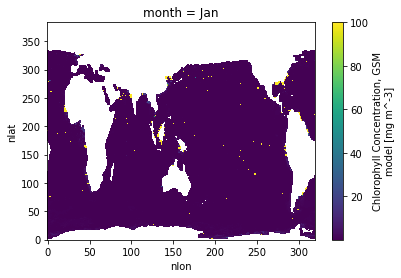

In [5]:
#plot Observational Data:
dsobs.chl_gsm.sel(month='Jan').plot();

obs data shape: (12, 384, 320) model data shape: (12, 384, 320)


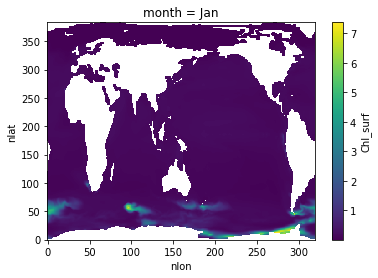

In [6]:
#plot CESM:
dsmod.Chl_surf.sel(month='Jan').plot();
print('obs data shape:', dsobs.chl_gsm.shape, 'model data shape:', dsmod.Chl_surf.shape)

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


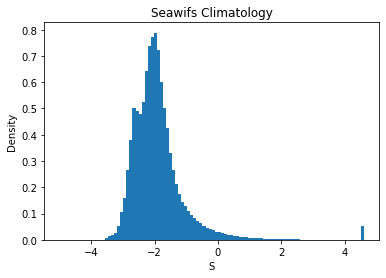

In [7]:
## Histograms of Seawifs
obs_log_trans = np.log(dsobs.chl_gsm.where(dsobs.chl_gsm>0))
plt.figure()
plt.hist(obs_log_trans.values.ravel(), 100, density=True);
plt.title('Seawifs Climatology')
plt.xlabel('S')
plt.ylabel('Density');

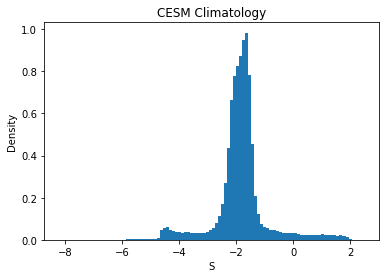

In [8]:
## Histograms of Seawifs
mod_log_trans = np.log(dsmod.Chl_surf.where(dsmod.Chl_surf>0))
plt.figure()
plt.hist(mod_log_trans.values.ravel(), 100, density=True);
plt.title('CESM Climatology')
plt.xlabel('S')
plt.ylabel('Density');

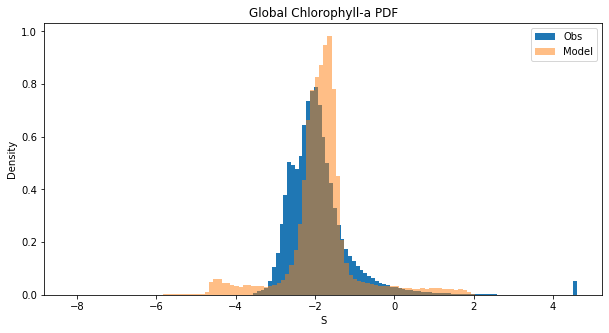

In [9]:
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()

plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Obs');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model');
plt.xlabel('S')
plt.title('Global Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig(save_path+'model vs obs chl compare feb 5.png')

## Make Regional PDFs

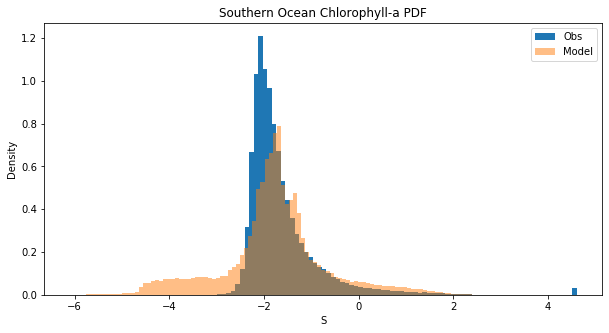

In [11]:
#Subset to Southern Ocean
ds_ob_so = dsobs.where(dsobs.TLAT <= -45)
ds_mod_so = dsmod.where(dsmod.TLAT <= -45)
#Log transform the data
mod_log_trans = np.log(ds_mod_so.Chl_surf.where(ds_mod_so.Chl_surf>0 & (ds_mod_so.TLAT <= -45)))
obs_log_trans = np.log(ds_ob_so.chl_gsm.where(ds_ob_so.chl_gsm>0 & (ds_ob_so.TLAT <= -45)))
#Make them a vector
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Obs');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model');
plt.xlabel('S')
plt.title('Southern Ocean Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig(save_path+'model vs obs chl compare feb 5.png')

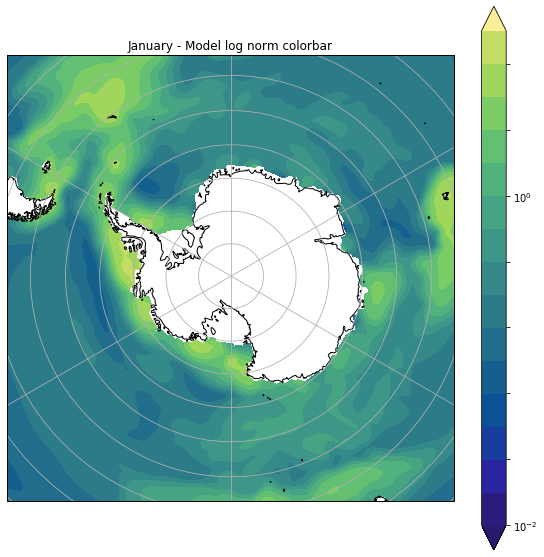

In [71]:
#PLOT IT
dsp = util.pop_add_cyclic(dsmod)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 100)), dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.Chl_surf.isel(month=0, nlat=slice(0, 100))
#field = np.log(dsp.Chl_surf.isel(month=0, nlat=slice(0, 100)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January - Model log norm colorbar')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)

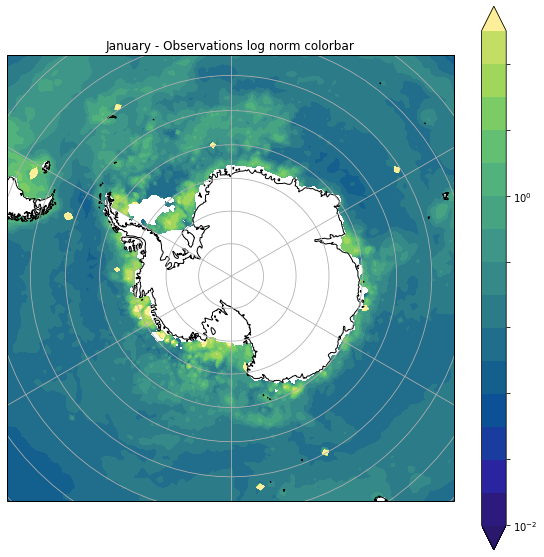

In [56]:
#PLOT IT
dsp = util.pop_add_cyclic(dsobs)

#Data:
lon = dsp.TLONG.isel(nlat=slice(0, 100))
lat = dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.chl_gsm.isel(month=0, nlat=slice(0, 100))

#Set up Figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
norm = colors.LogNorm(vmin=0.01, vmax=20.)
levels = np.logspace(-2, 1, 16)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January - Observations log norm colorbar')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)

## Map out Things

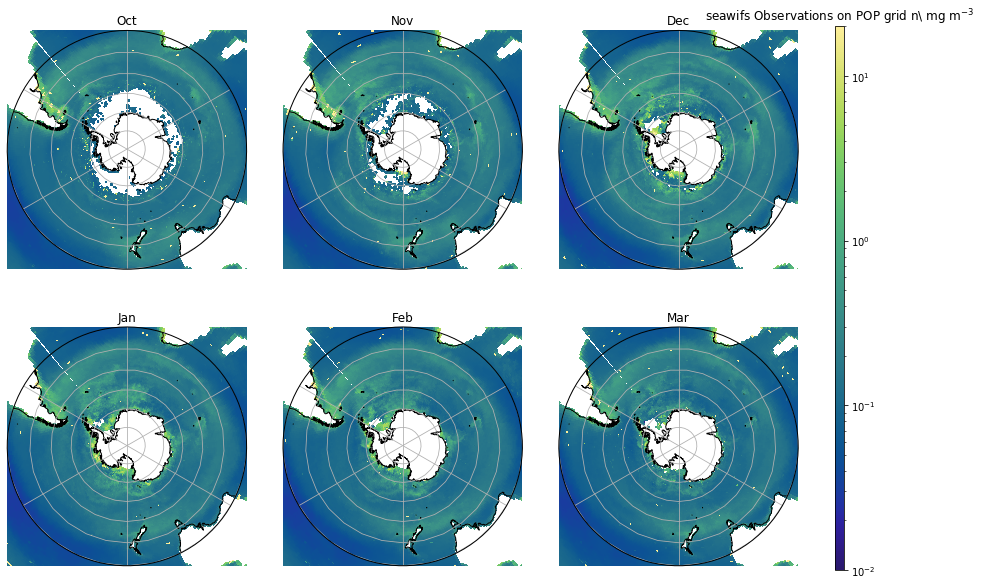

In [73]:
cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

lat = dsobs.TLAT.values
lon = dsobs.TLONG.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = dsobs.chl_gsm.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('seawifs Observations on POP grid n\ mg m$^{-3}$');

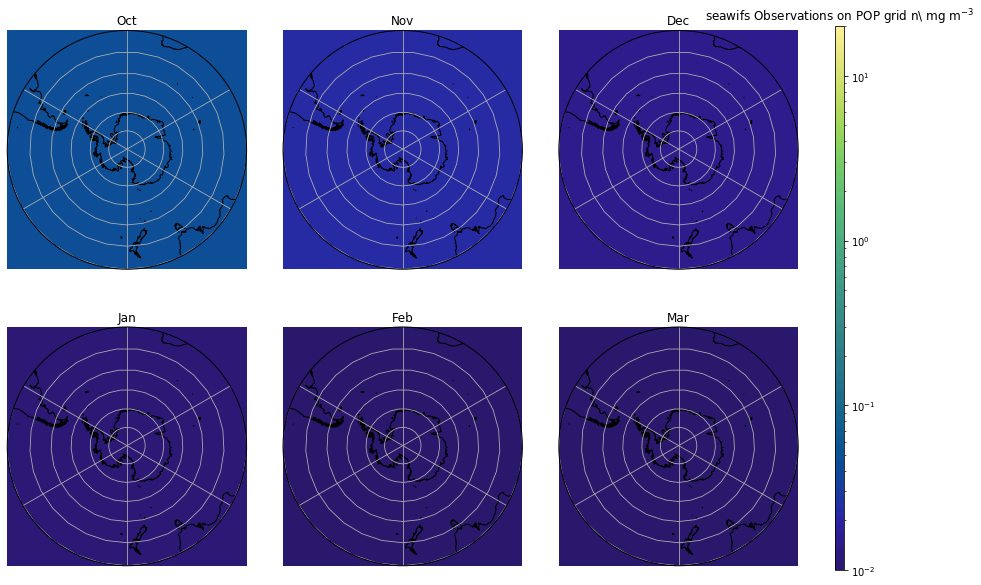

In [74]:
cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

lat = dsp.TLAT.values
lon = dsp.TLONG.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = dsp.Chl_surf.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('seawifs Observations on POP grid n\ mg m$^{-3}$');

## REGIONALIZE


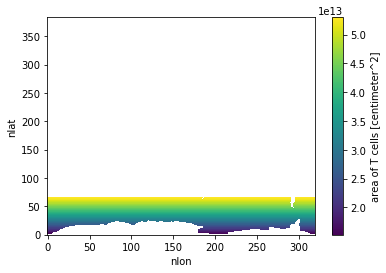

In [96]:
SO_mask = dsmod.TAREA.where((dsmod.TLAT <= -44) & (dsmod.KMT > 0))
SO_mask.plot()

In [106]:
dsz = dsobs.chl_gsm.where(

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [105]:
ds_pacific = ds_so_ob.chl_gsm.where(ds_so_ob.TLONG <= 292, & ds_so_ob.TLONG >= 20)

AttributeError: 'DataArray' object has no attribute 'chl_gsm'

# Creating Regions with POP-TOOLS

In [134]:
mos = np.arange(len(dsobs.month))


Set up region mask for major basins


In [119]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [120]:
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

In [122]:
region_defs = {'Atlantic SO': [{'match':
                             {'REGION_MASK': [1]},
                            'bounds':
                             {'TLAT': [-90., -44.], 'TLONG': [292., 20.]}}],
               'Pacific SO': [{'match':
                             {'REGION_MASK': [1]},
                            'bounds':
                             {'TLAT': [-90., -44.], 'TLONG': [147., 292.]}}],
              'Indian SO':  [{'match':
                             {'REGION_MASK': [1]},
                            'bounds':
                             {'TLAT': [-90., -44.], 'TLONG': [20., 147.]}}],}

mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs,
                                  mask_name='Southern Ocean Quadrants')

#### Pacific

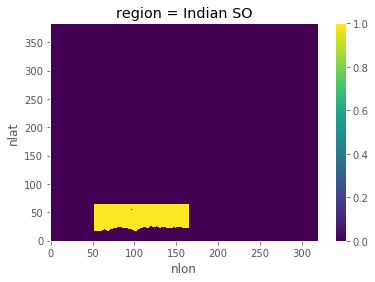

In [125]:
regnum=2
mask3d.isel(region=regnum).plot();

In [132]:
ds_pac_obs = dsobs
ds_pac_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*mask3d.isel(region=regnum), weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()

ds_pac = dsmod
ds_pac['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*mask3d.isel(region=regnum), weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()


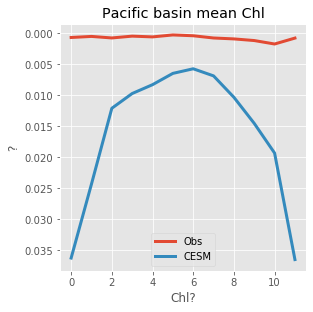

In [137]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific basin mean Chl')
ax.plot(ds_pac_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_pac['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='?',xlabel='Chl?')
plt.gca().invert_yaxis()

#### Atlantic


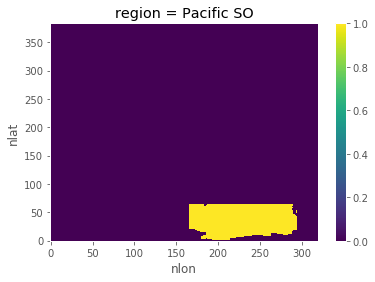

In [138]:
regnum=1
mask3d.isel(region=regnum).plot();

In [139]:
ds_at_obs = dsobs
ds_at_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*mask3d.isel(region=regnum), weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()

ds_at = dsmod
ds_at['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*mask3d.isel(region=regnum), weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()


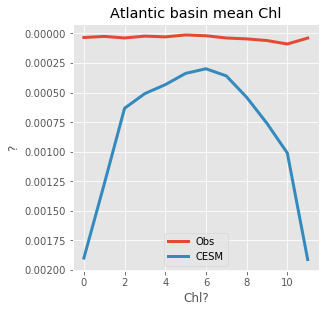

In [141]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Atlantic basin mean Chl')
ax.plot(ds_at_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_at['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='?',xlabel='Chl?')
plt.gca().invert_yaxis()

In [118]:
#KK setup
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')